In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from transformers import CLIPModel
from transformers import CLIPProcessor
import time
import faiss
from rank_bm25 import BM25Okapi

In [2]:
def display_images_and_titles(filepaths, titles): #display images
    # Create a 4x5 grid of subplots
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))

    # Loop through the filepaths and display images in the subplots
    for i, ax in enumerate(axes.flatten()):
        if i < len(filepaths):
            filepath = filepaths[i]
            image = plt.imread(filepath)
            ax.imshow(image)
            ax.axis('off')

            # Assign a title to each subplot
            ax.set_title(f"{titles[i]}", fontsize = 7)
        else:
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def display_images_titles_from_ids(ids, directory): 
    df_new_index = df.copy()
    df_new_index['id'] = df_new_index['id'].astype(str)
    df_new_index.set_index("id",inplace = True)
    df_new_index = df_new_index.loc[ids]
    filenames = df_new_index.index.tolist()
    filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
    titles =  df_new_index.productDisplayName.tolist()
    
    display_images_and_titles(filepaths, titles)

In [17]:
def CLIP_setup(): #get model and processor
    #Import CLIP Model
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") 
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    return model, processor

def dataset_vector(df): #use CLIP on dataset
    #Create vectors for dataset
    image_vectors = torch.load("image_tensor.pt")
    image_labels = df.id.astype(str).tolist() #also for text?
    text_vectors = torch.load("title_tensor.pt")
    
    # Convert data to numpy arrays for use with faiss
    image_np = image_vectors.numpy()
    text_np = text_vectors.numpy()

    # Build the index
    idim = image_np.shape[1]# Dimension of the vectors
    tdim = text_np.shape[1]# Dimension of the vectors
    indexi = faiss.IndexFlatL2(idim)
    indexi.add(image_np)
    indext = faiss.IndexFlatL2(tdim)
    indext.add(text_np)
    
    return indext, indexi, image_labels
 
def image_vector(image,model,processor): #use CLIP on uploaded image
    #set chosen inmage and text
    my_image = Image.open(image)
    text=["text"]
    
    #run through CLIP
    inputs = processor(text=text, images=my_image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    
    # Vector for image
    image_embedding = outputs.image_embeds.reshape(1, -1)
    
    return image_embedding

def image_knn(indext, indexi, image_labels, image_embedding): #run knn on uploaded image
    # Query the index
    k = 1000  # Number of neighbors to return
    D, I = indexi.search(image_embedding.detach().numpy(), k)
    
    # Get labels of the neighbors
    neighbor_labels = [image_labels[i] for i in I[0]]
    
    return I, neighbor_labels

def double_knn(df,image1,image2): #run knn on 2 uploaded images
    MandP=CLIP_setup()
    ie1=image_vector(image1,MandP[0],MandP[1])
    ie2=image_vector(image2,MandP[0],MandP[1])
    dv=dataset_vector(df)
    image_labels=dv[2]
    knn1=image_knn(dv[0],dv[1],image_labels,ie1)
    knn2=image_knn(dv[0],dv[1],image_labels,ie2)
    return knn1, knn2, image_labels

def intersection(knn1,knn2,image_labels): #intersect - need to update with sorting
    #Finds the common indexes from the image knn and text knn
    common_elements = np.intersect1d(knn1[0], knn2[0])

    #Makes common elements an array
    common_elements_array = common_elements.reshape(1, -1)
    
    combo_labels = [image_labels[i] for i in common_elements_array[0]]
    
    return combo_labels

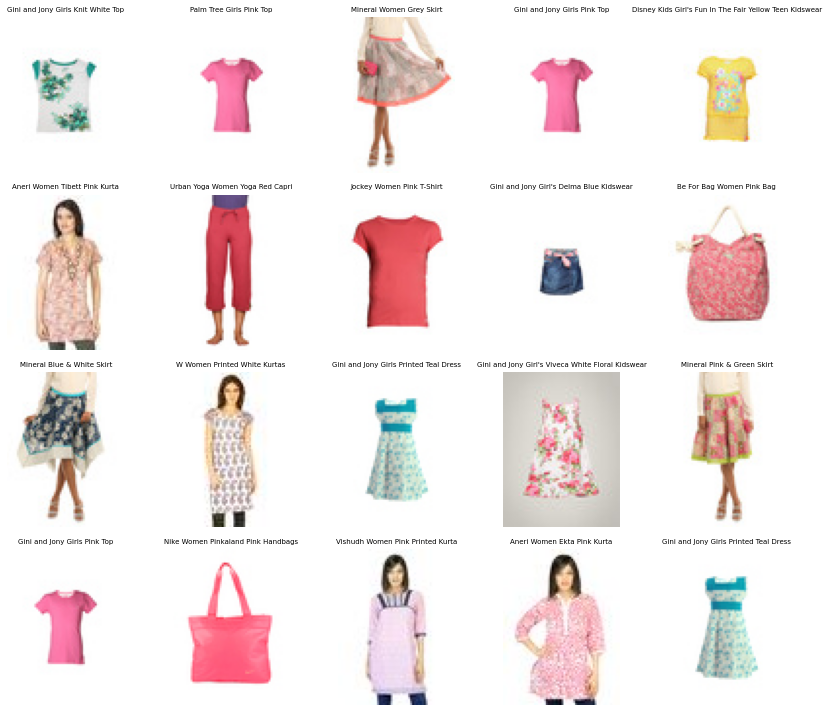

In [18]:
filename = "./myntradataset/styles.csv"
df = pd.read_csv(filename, on_bad_lines="skip") #some lines of the dataset fail due to excess commas

available_ids = os.listdir("./myntradataset/images")
available_ids = [int(x.replace(".jpg","")) for x in available_ids]
df = df[df.id.isin(available_ids)] #some images are not actually available
df=df.dropna(subset='productDisplayName')
image1 = "./ps.jpg" #Upload your first picture here
image2 = "./f.jpg" #Upload your second picture here
knn=double_knn(df,image1,image2)
combo_labels=intersection(knn[0],knn[1],knn[2])
directory = "./myntradataset/images/"
display_images_titles_from_ids(combo_labels, directory)